# Photophysics of the Nitrogen-Vacancy (NV) Center in Diamond 

The nitrogen vacancy center (NV center) is the most well studied point defect in diamond, consisting of a substituational nitrogen atom and adjacent vacancy along the 111-crystal axis of the diamond lattice. Its ability to locally detect and measure a number of physical quantities, such as magnetic and electric fields, makes it a promising candidate for quantum sensing, computing and communication applications.

The electronic ground state of the negatively charged NV center is a spin triplet (S= 1) whose spin state can be optically prepared and read-out using green light illumination. This optical addressability enables detection of single NV centers with high sensitivity by means of optically detected magnetic resonance.

In this example notebook we will explore the photophysics of the NV center and theoretically assess optical spin-polarization and spin-dependent fluorescence. Starting from a pseudo-classical rate model we will gradually evolve to a fully quantum mechanical model that accounts for effects of magnetic and electric fields as well as temperature.

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import simos as sos

## A simple, (pseudo)-classical rate model

We begin with a simple, pseudo-classical rate model of the negatively charged NV center, encompassing a triplet ground state, a triplet excited state as well as a metastable singlet state.

The excited state lies 1.945 eV (637 nm) above the ground state. Here, we consider off-resonant excitation of the NV center from the ground to the excited state, which is commonly achieved with green (~532 nm) laser light. 
The excited state has an optical lifetime of about 16 ns and decays either radiatively by emission of a red photon, or nonradiatively via an intersystem crossing (ISC) to the metastable singlet state. 

This ISC is strongly spin dependent, resulting in (i) higher fluorescence intensity for the $m_S = 0$ spin state versus the $m_S = 1$ spin state and (ii) polarization of the spin state to $m_S = 0$ throughout multiple excitation-decay cycles.  


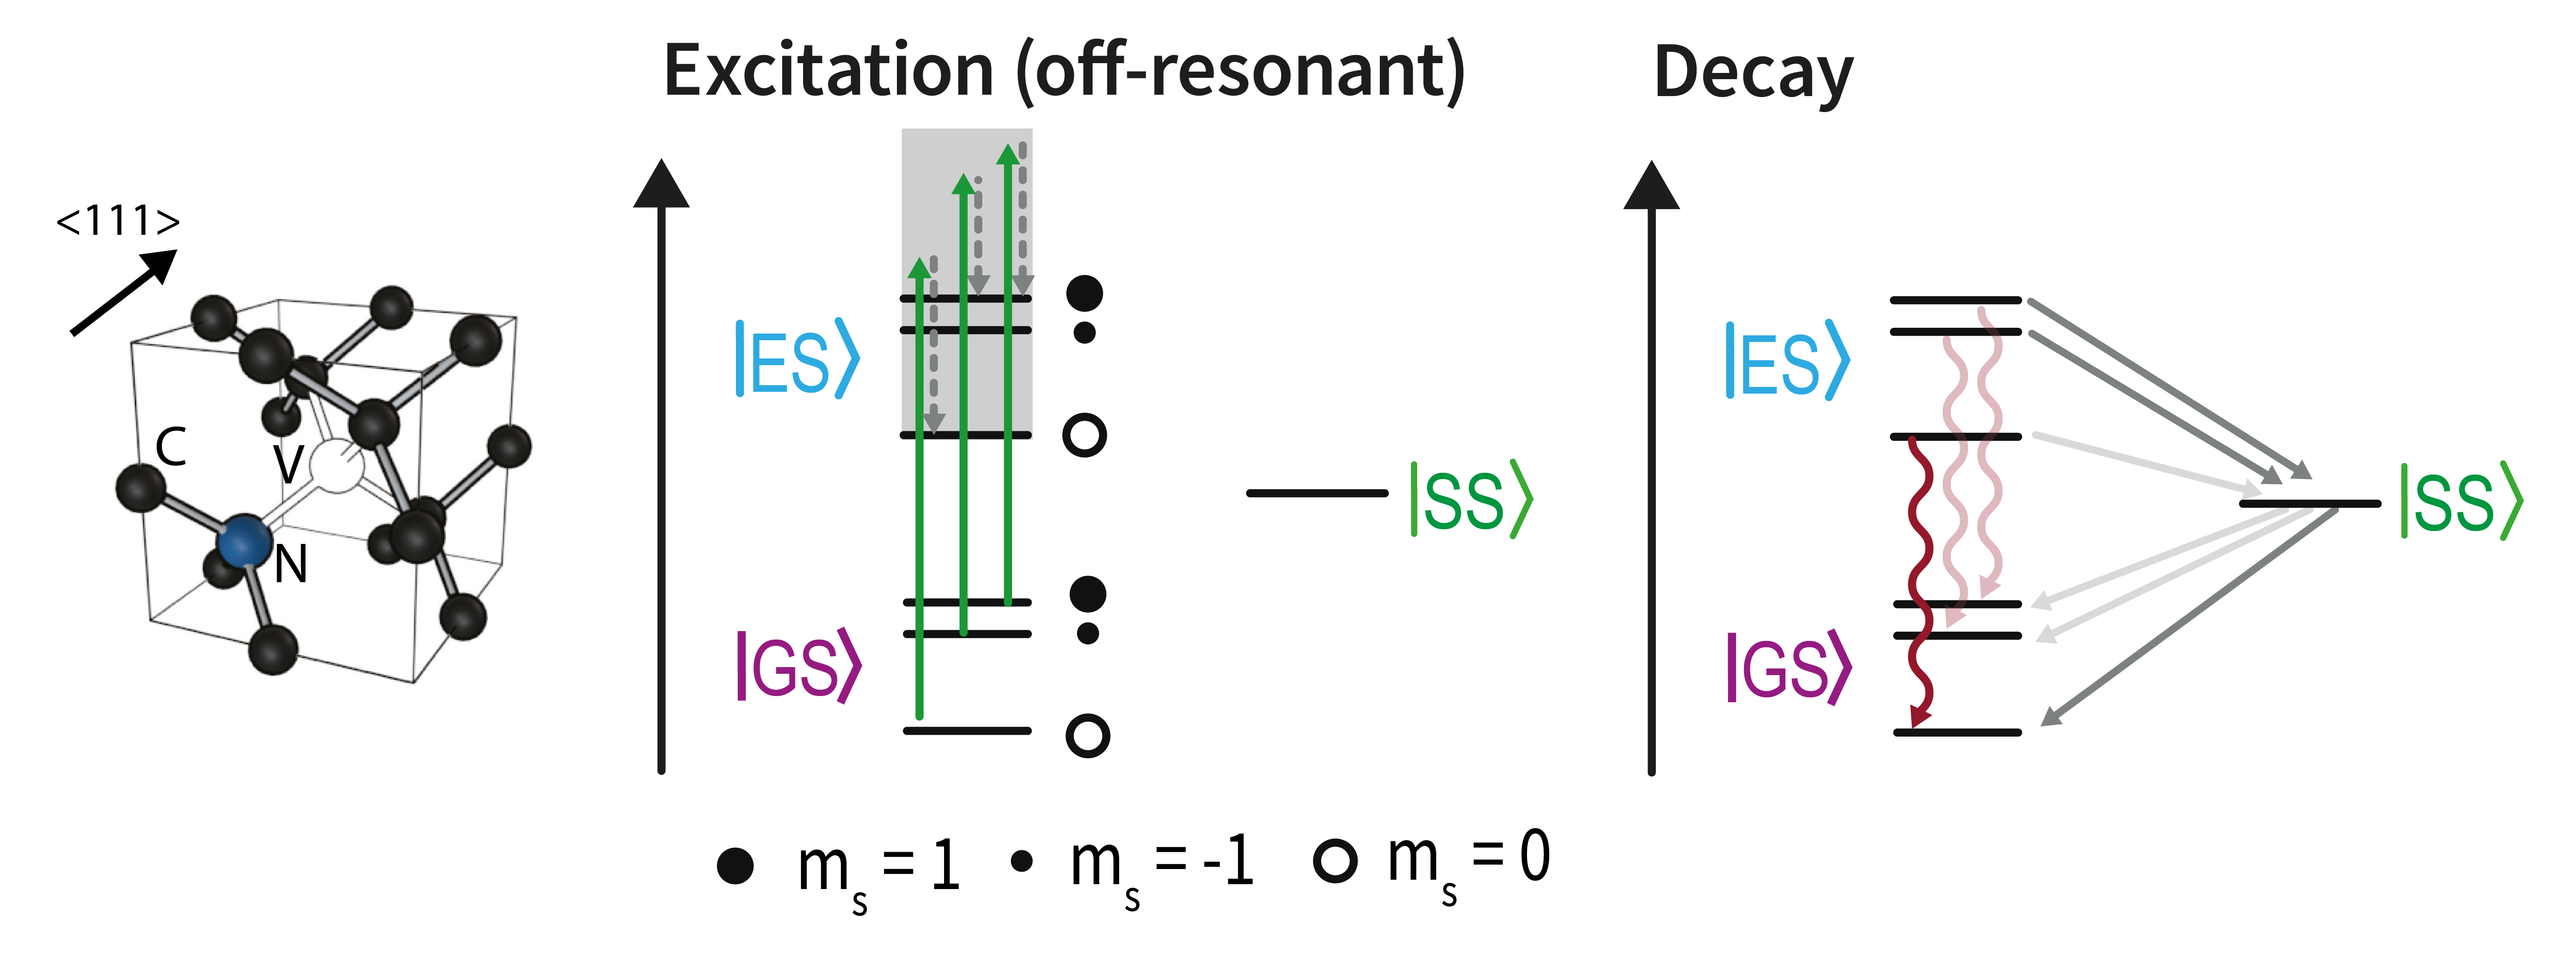

In [36]:
from IPython.display import Image
Image(filename='img/NV_simplescheme.png', width=400)

We will now simulate the spin-dependent fluorescence of an NV center during laser illumination using this model. We start by concstructing the Hilbert space of the NV center:

In [86]:
# NV center electron spin
S = {'val': 1, 'name':'S', 'type': 'NV-'} 

# Electronic states
GS = {'val': 0 , 'name':'GS'}
ES = {'val': 0 , 'name':'ES'}
SS = {'val': 0 , 'name':'SS'}

NV = sos.System(([(GS, ES), S], SS), method = "qutip")

We continue to define the rates for the optical transions.

In [87]:
# All rates are in 1/s
emission_rate = 55.7e6

NV_rates = {}

#  GS <-> ES transitions
NV_rates["ES,S[1]->GS,S[1]"]  = emission_rate
NV_rates["ES,S[-1]->GS,S[-1]"] = emission_rate
NV_rates["ES,S[0]->GS,S[0]"] = emission_rate

# Spin dependent rates for the ISC (Intersystem crossing) process
NV_rates["ES,S[1]->SS"] = 98.7e6
NV_rates["ES,S[-1]->SS"] = 98.7e6
NV_rates["ES,S[0]->SS"] = 8.2e6

# decay from shelving to ground state
NV_rates["SS->GS,S[0]"] = 4.8e6
NV_rates["SS->GS,S[1]"] = 2.2e6
NV_rates["SS->GS,S[-1]"] = 2.2e6

# tidyup the rate dictionary
NV_rates = sos.tidyup_ratedict(NV, NV_rates)

# Laser excitation
laser_rates = {"GS,S[0]->ES,S[0]": 0.2*emission_rate}
laser_rates["GS,S[1]->ES,S[1]"] = 0.2*emission_rate
laser_rates["GS,S[-1]->ES,S[-1]"] = 0.2*emission_rate

laser_rates = sos.tidyup_ratedict(NV, laser_rates)

For the moment, we ignore any coherent interactions and solely consider incoherent optical transitions.

Since we are interested in the spin-dependence of the fluorescence (and the spin state initialisation), we will perform our simulation for three distinct initial spin states , a) a polarized state $m_s = 0$ in the electronic ground state (`rho0`) and b)  a polarized $m_s=-1$ state (`rho1`). The corresponding density matrices are indentical to the product of the projectors of the levels involved. 

Further, we define a measurement operator which we choose as the projector onto the excited state. (Note: The population of the excited state is proportional to the fluorescence.)

In [88]:
# Inital states
rho0 = NV.GSid*NV.Sp[0]
rho1 = NV.GSid*NV.Sp[1]

# Observables
fluoresence = NV.ESid #*emission_rate

# Observable for the GS spin state polarization (S_z)
pol = NV.GSid*NV.Sz

Now we can evolve the system. In a first step, we build all operators for the Liouvillian.

In [89]:
allrates = sos.fuse_dictionaries(NV_rates,laser_rates)
c_ops_on = sos.transition_operators(NV, allrates)
c_ops_off = sos.transition_operators(NV, NV_rates)

We now define our time axis for the propagation and run the simulation.

In [90]:
tax = np.linspace(0,3e-6,101)
luminesence0 = []
luminesence1 = []

for t in tax:
    rho = rho0.copy()
    rho = sos.evol(0*NV.id, t, rho, c_ops = c_ops_on)
    meas = sos.expect(fluoresence , rho)
    luminesence0.append(meas)

    rho = rho1.copy()
    rho = sos.evol(0*NV.id, t, rho, c_ops = c_ops_on)
    meas = sos.expect(fluoresence , rho)
    luminesence1.append(meas)


Text(0, 0.5, 'Fluorescence [a.u.]')

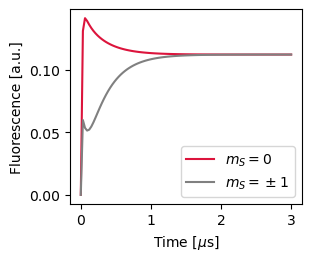

In [91]:
fig, ax = plt.subplots(1, 1, figsize = (3,2.5), layout = "constrained")

ax.plot(tax/1e-6,luminesence0, label = r"$m_S=0$", color = "crimson")
ax.plot(tax/1e-6, luminesence1, label = r"$m_S=\pm1$", color = "grey")

ax.legend()
ax.set_xlabel(r"Time [$\mu$s]")
ax.set_ylabel(r"Fluorescence [a.u.]")
#plt.plot(luminesencetm)


In [92]:
fig.savefig("NVsimple.pdf")

We can clearly observe (i) the spin dependent fluorescence of the NV center and (ii) the initialisation fo the spin state (polarization to $m_S = 0$ is achieved after approximately 1 $\mu$ s at this laser power).

Note that the code shown above for the time propagation is intuitive and easy to understand, yet inefficient. Since all interactions in our example are time-independent, we can run the time propagation more efficient by caching the propagator  superoperator for a single time step:

In [68]:
dt = 10e-9 # time step 
Ubright = sos.evol(0*NV.id, dt, c_ops = c_ops_on) # propagator when laser is on 
Udark = sos.evol(0*NV.id, dt, c_ops = c_ops_off) # propagator when laser is off

Let's run the simulation again this way - you will see, it is much quicker!

In [69]:
luminesence0 = []
luminesence1 = []
spin0 = []
spin1 = []
laser_state = []

pts = 400
rho0 = NV.GSid*NV.Sp[0]
rho1 = NV.GSid*NV.Sp[1]
for i in range(pts):
    meas = sos.expect(fluoresence , rho0)
    luminesence0.append(meas)
    meas = sos.expect(NV.Sp[0],rho0)
    spin0.append(meas)

    meas = sos.expect(fluoresence , rho1)
    luminesence1.append(meas)
    meas = sos.expect(NV.Sp[0],rho1)
    spin1.append(meas)


    if  i in range(50,250):
        rho0 = sos.applySuperoperator(Ubright,rho0)
        rho1 = sos.applySuperoperator(Ubright,rho1)
        laser_state.append(1)
    else:
        rho0 = sos.applySuperoperator(Udark,rho0)
        rho1 = sos.applySuperoperator(Udark,rho1)
        laser_state.append(0)

<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
/var/folders/76/fcyqxs151lz21dxgschkb9pm0000gn/T/ipykernel_5210/1911819283.py:24: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("Time ($\mu$s)")


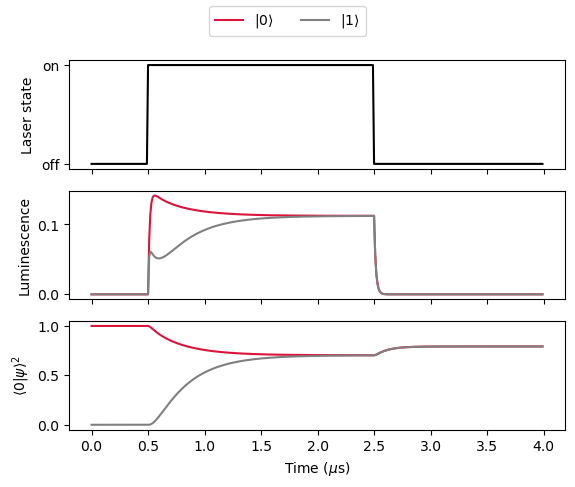

In [73]:
tax = np.arange(pts)*dt*1e6 # in us

# make a 3 panel plot with a shared x axis

fig, axs = plt.subplots(3, sharex=True)

# Laser state in black top most panel
axs[0].plot(tax,laser_state, 'k')
axs[0].set_ylabel("Laser state")
# set ticks on y to text: 0: off and 1: on
axs[0].set_yticks([0,1])
axs[0].set_yticklabels(["off","on"])

# Luminescence in the middle panel
axs[1].plot(tax,luminesence0,label="$|0\\rangle$",color='crimson')
axs[1].plot(tax,luminesence1,label="$|1\\rangle$",color='grey')
axs[1].set_ylabel("Luminescence")

# Spin state in the bottom panel
axs[2].plot(tax,spin0,color='crimson')
axs[2].plot(tax,spin1,color='grey')
axs[2].set_ylabel("$\\langle 0 | \\psi \\rangle^2$")

plt.xlabel("Time ($\mu$s)")
# shared legend below the plot
fig.legend(loc='upper center', ncol=3)



Note that you can also use the ``simos.prop`` method to propagate the system. This method is a wrapper around parametrized time-dependent Hamiltonians and/or Liouvillians. It is the most efficient way to propagate the system.

# A full quantum mechanical model

We now continue to explore a comprehensive model of the spin dynamics of the negatively charged NV center, spanning the full temperature range from the low-to the high-temperature regime, including effects of applied magnetic and electric field bias.

For all details, see DOI: 10.1103/PhysRevB.108.085203.

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import simos as sos
import scipy as sc

Again and in full analogy to the simple model above we start by setting up the NV center system and only consider the negatively charged state and neglect hyperfine couplings to surrounding nuclei.

However, we now take into account that the excited state (ES) of the NV center is an orbital doublet at cryogenic temperature. At room temperature rapid phonon-driven transitions result in an averaging to an effective orbital singlet. The interplay of spin and orbital dynamics in the ES results in fast spin relaxation and vanishing ODMR contrast at intermediate temperatures.  To capture these effects we have to explicitly introduce the ES as an orbital doublet. We do so by defining it with a value = 1/2 making it an effective two-level system. 

In [75]:
# Spin NV , S=1:
S = {'val': 1, 'name':'S'} 
# Electronic Ground State NV- :
GS = {'val': 0 , 'name':'GS'}
# Electronic Excited State NV-, Orbital doublet:
ES = {'val': 0.5 , 'name':'ES'}
# Metastable Shelving State NV- :
SS = {'val': 0 , 'name':'SS'}

# Construct the system:
NV = sos.System(([(GS, ES), S], SS), method = "qutip")

In our full model, we will also take into account the coherent dynamics of the NV center. Therefore, we must define the strengths of both, incoherent and coherent interactions.   
You can find detailed explanations for these interactions in the original reference (DOI: 10.1103/PhysRevB.108.085203.)
Here we assume a temperature T=  30 K, where reduced spin contrast is expected to be ovserved.

In [77]:
#### Interactions ###

### these are intrinsic NV properties and hold for all temperatures / fields ### 

# Zero-field splitting of the NV center GS
DGS = 2.878e9 # Hz 
# Zero-field splitting of the NV center ES
DESpara =  1.44e9 # Hz 
DESperp =  1.541e9 # Hz
# g factor of the electron
g = 2.003  #a.u.
# Spin-orbit interaction in the ES
lambdaESpara = 5.33e9 # Hz
lambdaEsperp = 0.154e9 # Hz 
# G value of the ES orbit. 
gorb = 0.1 # a.u. 

### Fields: Crystal Strain and External B-Field ###
### below we provide some default values, may be adjusted ### 

E_perp = 40e9 # axial strain Hz 
phi_E = 0 # degrees
Evec = sos.spher2cart(E_perp, np.deg2rad(90), np.deg2rad(phi_E))[0] # strain in cartesian coordinates 
B = 0e-3 # T 
theta_B = 0 # degrees
phi_B = 0 # degrees
Bvec = sos.spher2cart(B, theta_B, phi_B)[0] # Bield in cartesian coordinates 

### Optical Transition Rates ###  

# Optical emission from the ES to the GS 
kr = 55.7e6 # Hz
# Average intersystem crossing rate for ms pm 1
kE12 = 98.7e6 # Hz
# Inersystem crossing for ms 0 
kExy = 8.2e6 # Hz
# ES branching ratio 
rbeta = 1
# SS branching ratio 
rs = 2.26
#  SS emitted phonon energy 
deltaE = 16.6e-3 # eV
# SS decay time t T = 0K 
tau = 320e-9 # s
# Temperature 
T = 30 # K
# ES electron phonon coupling strength 
eta = 176*1e15 # s/(eV)**3
# phonon cutoff energy 
Omega = 168e-3 #eV

kB = 8.6173e-5  # Boltzman constant, unit: eV/K
sq2 = 1/np.sqrt(2)
h = 4.135667696e-15 # Plank constant to convert energy in GHz to eV. Units: eV/Hz
hbar = h/(2*np.pi)

# Calculate further:
# x and y branch excitation rates 
beta = 0.2
betax = rbeta*beta/(1+rbeta)
betay = beta-betax
# ss to gs spin selective decay rates 
if T > 0 :
    tau = tau * (1-np.exp(-deltaE/(kB*T)))
s = 1/tau
s0 = rs*s/(1+rs)
s1 = s-s0

Delta = 2*E_perp

# Calculate the one phonon downwards rate 

if T > 0 :
    kdown1 = 32*eta*h**3*E_perp**3*(1/(np.exp(2*E_perp*h/(kB*T))-1) + 1)
else:
    kdown1 = 32*eta*h**3*E_perp**3
if kdown1 < 1e0:
    kdown1 = 0 

# Calculate the two phonon downwards rate 
if T == 0:
    kdown2 = 0
else:
    phononcutoffenergy = 168e-3 # eV
    cutoff = phononcutoffenergy/(kB*T)
    x_perp = 2*h*E_perp/(kB*T)
    def DebyeIntegrandTwoEmissions(x, T, Delta):
        x_perp = h*Delta/(kB*T)
        if x > x_perp:
            return 0. 
        else:
            dividend = 0.5 * np.exp(-x+x_perp) * x * (-x+x_perp) * (x**2 + (-x+x_perp)**2)
            divisor = np.exp(-x+x_perp) - 1 - np.exp(-2*x+x_perp) + np.exp(-x)
            return dividend/divisor if divisor!=0. else 0. 
    Integral = sc.integrate.quad(DebyeIntegrandTwoEmissions, 0, min(x_perp, cutoff), args = (T, Delta))[0]
    kdown2 = (64/np.pi) * hbar * eta**2*kB**5*T**5  * Integral # fac4? 
    khopplimit = 250e12 # Hz 
    kdown2 = np.min([kdown2, khopplimit])
    if kdown2 < 1e0:
        kdown2 = 0 

# Calculate total downwards and upwards rates from here 
kdown = kdown1+ kdown2
if T > 0:
    kup = kdown * np.exp(-2*h*E_perp/(kB*T))
else:
    kup = 0 

We set up the system Hamiltonian ... 

In [78]:
# Ground state Hamiltonian , Zero-field splitting and zeeman interaction 
mub = 9.2740100783e-24

# ZFS GS
HGS =  sos.f2w(DGS)* ((NV.Sz*NV.GSid)**2 - 2/3*NV.Sid*NV.GSid)  # checked for unit 
# Zeeman GS
HGS += ((sos.mub*g)/sos.hbar) * (NV.Sx*NV.GSid*Bvec[0] + NV.Sy*NV.GSid*Bvec[1] + NV.Sz*NV.GSid*Bvec[2])

# Excited state Hamiltonian

# ZFS
HES =  sos.f2w(DESpara) * ((NV.Sz*NV.ESid)**2 - 2/3*NV.Sid*NV.ESid) + sos.f2w(DESperp)*(2*NV.ESz*(NV.Sy**2 -NV.Sx**2) - 2*NV.ESx*(NV.Sy*NV.Sx + NV.Sx*NV.Sy))
# Spin-Orbit 
HES += - sos.f2w(lambdaESpara)*2*NV.ESy*NV.Sz  + sos.f2w(lambdaEsperp)*(2*NV.ESz*(NV.Sx*NV.Sz + NV.Sz*NV.Sx) - 2*NV.ESx*(NV.Sy*NV.Sz + NV.Sz*NV.Sy))
# Zeeman 
HES += ((sos.mub*g)/sos.hbar) * (NV.Sx*NV.ESid*Bvec[0] + NV.Sy*NV.ESid*Bvec[1] + NV.Sz*NV.ESid*Bvec[2])
HES += ((sos.mub*gorb)/sos.hbar)*Bvec[2]*2*NV.ESy*NV.Sid
# Strain
HES +=  sos.f2w(Evec[0])*2*NV.ESz*NV.Sid

H = HGS+ HES

... and further define all collapse operators for the optical transitions. However, while the Zeeman basis was sufficient to describe optical transitions in our simple model, the full quantum mechanical model requires two additional basis sets. Here we consider the special case of zero magnetic field (B=0) in which only one additional basis is required. 
Agian, we refer the user of this code to the original publication for an in-depth explanation of the role and use of the various basis sets. 

In [79]:
T_zftoez =  np.array(
       [[ 1,    0,    0,     0,    0,    0,    0,    0,    0 , 0 ],
        [ 0,    1,    0,     0,    0,    0,    0,    0,    0 , 0 ],
        [ 0,    0,    1,     0,    0,    0,    0,    0,    0 , 0 ],
        [ 0,    0,    0, -1j/2,  1/2,    0,    0,-1j/2, -1/2  , 0],
        [ 0,    0,    0,     0,    0,    0,    1,    0,    0 ,0 ],
        [ 0,    0,    0, -1j/2, -1/2,    0,    0,-1j/2,  1/2 ,0 ],
        [ 0,    0,    0,   1/2, 1j/2,    0,    0, -1/2, 1j/2  ,0],
        [ 0,    0,    0,     0,    0,    1,    0,    0,    0 ,0 ],
        [ 0,    0,    0,  -1/2, 1j/2,    0,    0,  1/2, 1j/2 ,0 ],
        [ 0,    0,    0,     0,    0,    0,    0,    0,    0 , 1 ]])

T_eztozf = np.transpose(T_zftoez)
NV.add_basis(T_eztozf, "zf", ["GS1", "GS0", "GSm1", "E1", "E2", "Ey0", "Ex0", "A1", "A2", "SS"])


In [80]:
# All rates are in 1/s
NV_rates = {}

#  GS <-> ES transitions (laser excitation and fluorescent decay)
NV_rates["GS,S[0] -> ES[-0.5],S[0]"] =  betax*kr
NV_rates["GS,S[0] -> ES[0.5],S[0]"] =  betay*kr
NV_rates["GS,S[1] -> ES[-0.5],S[1]"] = betax*kr
NV_rates["GS,S[1] -> ES[0.5],S[1]"] = betay*kr
NV_rates["GS,S[-1] -> ES[-0.5],S[-1]"]  = betax*kr
NV_rates["GS,S[-1] -> ES[0.5],S[-1]"]  = betay*kr

NV_rates["GS,S[0] <- ES[-0.5],S[0]"] =  kr
NV_rates["GS,S[0] <- ES[0.5],S[0]"] =  kr
NV_rates["GS,S[1] <- ES[-0.5],S[1]"] = kr
NV_rates["GS,S[1] <- ES[0.5],S[1]"] = kr
NV_rates["GS,S[-1] <- ES[-0.5],S[-1]"]  = kr
NV_rates["GS,S[-1] <- ES[0.5],S[-1]"]  = kr

# Spin dependent rates for the ISC (Intersystem crossing) process
NV_rates["zf_A1->zf_SS"] = kE12/0.52
NV_rates["zf_E1->zf_SS"] = kE12
NV_rates["zf_E2->zf_SS"] = kE12
NV_rates["zf_Ex0->zf_SS"] = kExy
NV_rates["zf_Ey0->zf_SS"] = kExy

# Spin dependent decay from shelving to ground state
NV_rates["SS->GS,S[0]"] = s0
NV_rates["SS->GS,S[1]"] = s1
NV_rates["SS->GS,S[-1]"] = s1

# Phonon induced transition rates
NV_rates["ES[-0.5],S[1] -> ES[0.5],S[1]"] = kup
NV_rates["ES[-0.5],S[0] -> ES[0.5],S[0]"] =  kup
NV_rates["ES[-0.5],S[-1] -> ES[0.5],S[-1]"] = kup
NV_rates["ES[-0.5],S[1] <- ES[0.5],S[1]"] = kdown
NV_rates["ES[-0.5],S[0] <- ES[0.5],S[0]"] =  kdown 
NV_rates["ES[-0.5],S[-1]<- ES[0.5],S[-1]"] = kdown

allrates = sos.tidyup_ratedict(NV, NV_rates)

In [82]:
# Inital states
rho0 = NV.GSid*NV.Sp[0]
rho1 = NV.GSid*NV.Sp[1]
rhotm = NV.GSid.unit()

# Observables
fluoresence = NV.ESid #*emission_rate

# Observable for the GS spin state polarization (S_z)
pol = NV.GSid*NV.Sz
c_ops_on = sos.transition_operators(NV, allrates)

tax = np.linspace(0,1e-6,201)
dt = tax[1]-tax[0]
luminesence0 = []
luminesence1 = []
U  = sos.evol(H, dt, c_ops = c_ops_on)
rho_0 = rho0.copy()
rho_1 = rho1.copy()

for t in tax:
    luminesence0.append(sos.expect(fluoresence , rho_0))
    luminesence1.append(sos.expect(fluoresence , rho_1))  
    rho_0 = sos.applySuperoperator(U,rho_0)
    rho_1 = sos.applySuperoperator(U,rho_1)


Text(0, 0.5, 'Fluorescence [a.u.]')

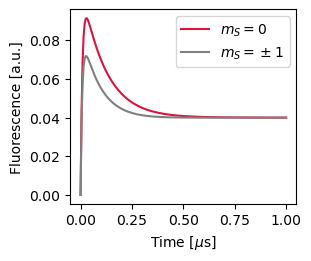

In [84]:
fig, ax = plt.subplots(1, 1, figsize = (3,2.5), layout = "constrained")

ax.plot(tax/1e-6,luminesence0, label = r"$m_S=0$", color = "crimson")
ax.plot(tax/1e-6, luminesence1, label = r"$m_S=\pm1$", color = "grey")

ax.legend()
ax.set_xlabel(r"Time [$\mu$s]")
ax.set_ylabel(r"Fluorescence [a.u.]")
#plt.plot(luminesencetm)

We clearly observe reduced spin contrast in the intermediate temperature regime. If you run the code again using a high temperature T=30, this model will give the same result as the classical model. 

## An outlook for this notebook

This notebook showcases how to simulate photophysics of NV centers with SimOS. It provides a basis to explore the influence of individual parameters (laser strength, magnetic fields etc.) on spin contrast and preparation.  